In [14]:
# Bibliothèques standard
import os
import math
from math import floor
import random

# Manipulation de données
import pandas as pd
import numpy as np

# Traitement de texte et NLP
import re
import string
from collections import defaultdict, Counter

# Transformers et PyTorch
from transformers import BertTokenizer, BertForMaskedLM, BertForSequenceClassification
import torch
import torch.nn.functional as F

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Monter Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# FUNCTIONS

def clean_text(sent:str) -> str:
    """
    Nettoie une phrase en supprimant les balises HTML.

    Args:
        sent (str): Phrase contenant éventuellement des balises HTML.

    Returns:
        str: Phrase nettoyée sans balises HTML.
    """
    text = re.sub(r"<.*?>", "", sent)
    return text


def masking(sentence: str) -> tuple[dict, dict]:
    """
    Applique un masquage aléatoire à une phrase tokenisée pour la tâche de modélisation de langage masqué.

    Args:
        sentence (str): Phrase d'entrée à masquer.

    Returns:
        tuple[dict, dict]:
            - Un dictionnaire contenant la phrase originale, la phrase de référence,
              le dictionnaire des tokens masqués, et la phrase masquée.
            - Un dictionnaire contenant les inputs encodés pour le modèle.
    """
    # Initialiser la graine pour les tirages aléatoires
    random.seed(42)

    orig_sent = sentence

    # Tokenisation et encodage avec `return_tensors="pt"`
    encoded_inputs = tokenizer(
        sentence,
        add_special_tokens=True,  # Ajoute [CLS] et [SEP]
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    #print(f"{encoded_inputs=}")

    # Récupérer les IDs tokenisés
    encoded_tokens = encoded_inputs["input_ids"].squeeze(0)  # Supprime la dimension batch
    #print(f"{encoded_tokens=}")

    # Décodage pour obtenir les tokens et la phrase complète
    decoded_tokens = tokenizer.convert_ids_to_tokens(encoded_tokens)
    #print(f"{decoded_tokens=}")
    decoded_sentence = tokenizer.convert_tokens_to_string(decoded_tokens)
    #print(f"{decoded_sentence=}")

    # Calculer le nombre de tokens à masquer (15%)
    n_tokens = len(decoded_tokens) - 2
    n_mask = max(1, round(0.15 * n_tokens))
    #print(f"Nombre total de tokens valides : {n_tokens}, Nombre de tokens à masquer : {n_mask}")

    # Sélection aléatoire des indices à masquer
    masked_idx = []
    while len(masked_idx) < n_mask:
        random_number = randint(1, n_tokens)  # Exclure [CLS] et [SEP]
        if random_number not in masked_idx:
            masked_idx.append(random_number)

    masked_dict = {idx: decoded_tokens[idx] for idx in masked_idx}
    #print(f"{masked_dict=}")

    # Créer une copie des encoded_tokens pour les tokens masqués
    encoded_masks_ts = encoded_inputs["input_ids"]

    # Appliquer la stratégie de masquage (80-10-10)
    for idx in masked_idx:
        #print(f"{idx=}")
        prob = torch.rand(1).item()
        if prob < 0.8:
            encoded_masks_ts[0, idx] = tokenizer.mask_token_id  # Remplace par `[MASK]`
        elif prob < 0.9:
            # Remplace par un token aléatoire
            encoded_masks_ts[0, idx] = torch.randint(0, tokenizer.vocab_size, (1,)).item()
        # Sinon, laisse le token inchangé (10%)
    #print(f"Input IDs après masquage : {encoded_masks_ts}")

    # Convertir les `encoded_masks_ts` en texte
    encoded_masks = encoded_masks_ts.squeeze(0)
    #print(f"{encoded_masks=}")

    masked_tokens = tokenizer.convert_ids_to_tokens(encoded_masks)
    masked_sentence = tokenizer.convert_tokens_to_string(masked_tokens)
    #print(f"Phrase avec le masquage : {masked_sentence}")

    # Dictionnaire des résultats
    sent_dict = {
        "original_sentence": orig_sent,
        "reference_sentence": decoded_sentence,
        "masked_dict": masked_dict,
        "masked_sentence": masked_sentence
    }

    encoded_inputs["input_ids"] =  torch.tensor(encoded_masks_ts)

    return sent_dict, encoded_inputs


In [16]:



def compute_tokens(text:str, punct:list) -> tuple[int, int, int]:
    """
    Calcule le nombre de tokens dans un texte après suppression de la ponctuation
    et vérifie s'il dépasse une limite de 512 tokens.

    Args:
        text (str): Texte d'entrée à analyser.
        punct (list): Liste des caractères de ponctuation à supprimer.

    Returns:
        tuple[int, int, int]:
            - `lenght` (int): Nombre total de tokens dans le texte nettoyé.
            - `count` (int): Indicateur (1 si le texte dépasse 512 tokens, sinon 0).
            - `over` (int): Nombre de tokens en excès si la limite est dépassée.
    """

    over = 0
    count = 0
    without_punct = ""
    for char in text:
        if char not in punct:
            without_punct += char
    #print(without_punct)
    tokens = without_punct.split()
    #print(tokens)
    lenght = len(tokens)
    #print(f"{lenght=}")

    if lenght > 512:
        count = 1
        over = lenght - 512

    return lenght, count, over


In [17]:
df_Test = pd.read_csv("/content/gdrive/My Drive/Doc_Struct_Projet/corpus_test/data_public_anglais_annotated_CEFR_dialang.csv")
rows = len(df_Test.axes[0])
print(f"{rows=}")
print("Repartition des labels sur tout le corpus :", Counter(df_Test["Note_dialang_ecrit"].tolist()))

#df_Test = df_Test.head(200)
#print("Repartition des labels sur les 200 premieres lignes:", Counter(df_Test["Note_dialang_ecrit"].tolist()))

df_Test = df_Test[["Note_dialang_ecrit", "Texte_etudiant"]]

df_Test["Texte_etudiant"] = df_Test["Texte_etudiant"].apply(lambda x: clean_text(x))
texts = df_Test["Texte_etudiant"].tolist()
labels = df_Test["Note_dialang_ecrit"].tolist()

print(texts)
print(labels)

#Initialisation de la liste des caractères de ponctuation
punct = list(string.punctuation)
print(punct)

count_dict_all = defaultdict(int)
count_over_512 = defaultdict(int)
tokens_over_512 = defaultdict(int)

for r in range(rows):
    count_tokens = 0
    label = labels[r]
    text = texts[r]
    #print(label, text)
    count_tokens, count_over, tokens_over = compute_tokens(texts[r], punct)
    count_dict_all[label] += count_tokens
    count_over_512[label] += count_over
    tokens_over_512[label] += tokens_over

print(count_dict_all)
print(count_over_512)
print(tokens_over_512)



rows=671
Repartition des labels sur tout le corpus : Counter({'B1': 264, 'B2': 153, 'A2': 145, 'A1': 59, 'C1': 44, 'C2': 6})
['The first part is description\ndsfsqdfqsdf text here and here and more and more and more and more\nand more\nand more.....\n the second part is your opinion\ntext here\nsjkljfg', 'Two students in marketing business have created "Elyze", an app for presidential elections. It\'s like Tinder, it helps people to find which candidates match with them. The app show you propositions from candidates whithout knowing their name, then you have to clic if you are agree or not. More propositions you answer and more results will be relevant. It give you a proportion of match with every candidates.\n At start the idea was really innovative and a good way to help people to make a choice. Everyone was enthusiastic about it. However some people highlights some problematic aspects that open my eyes about this app.\nFirst, the two students said they don\'t have a politic opinion 

In [30]:
def prediction(inputs, mask_dict, tokenizer, model_1, model_2, epsilon=0.000001):
    """
    Compare les performances de deux modèles de prédiction sur des tokens masqués.

    Args:
        inputs (dict): Données d'entrée encodées pour les modèles, contenant les IDs de tokens.
        mask_dict (dict): Dictionnaire associant les indices des tokens masqués à leurs valeurs réelles.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer pour décoder les prédictions des modèles.
        model_1 (transformers.PreTrainedModel): Premier modèle pour générer des prédictions.
        model_2 (transformers.PreTrainedModel): Deuxième modèle pour générer des prédictions.
        epsilon (float, optional): Petit terme ajouté pour éviter les divisions par zéro lors du calcul de la divergence KL.

    Returns:
        tuple:
            - `result_1` (dict): Résultats des prédictions du modèle 1, comptant les correspondances pour les top-1, top-5, et top-10.
            - `result_2` (dict): Résultats des prédictions du modèle 2, similaires à `result_1`.
            - `distance_KL` (float): Divergence KL entre les prédictions des deux modèles pour les tokens top-1.
            - `count_1, bin_1` (tuple): Comptes et bins des scores pour le modèle 1.
            - `count_2, bin_2` (tuple): Comptes et bins des scores pour le modèle 2.
    """

    result_1 = {
        "mask": [0],
        1: [0],
        5: [0],
        10: [0]
                }

    result_2 = {
        "mask": [0],
        1: [0],
        5: [0],
        10: [0]
                }

    count_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    bin_1 = defaultdict(list)

    count_2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    bin_2 = defaultdict(list)

    # Étape 1 : Prédictions avec le premier modèle
    with torch.no_grad():
        outputs_1 = model_1(**inputs)
        logits_1 = outputs_1.logits

    # Étape 2 : Prédictions avec le second modèle
    with torch.no_grad():
        outputs_2 = model_2(**inputs)
        logits_2 = outputs_2.logits

    # Trouver les indices de tous les tokens `[MASK]`
    mask_token_indices = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]
    n_mask = len(mask_token_indices)
    #print(f"{n_mask=}")
    result_1["mask"][0] = n_mask
    result_2["mask"][0] = n_mask

    # Étape 3 : Traitement des prédictions pour les tokens masqués
    #print("Prédictions pour chaque token [MASK] avec scores:")
    for idx in mask_token_indices:
        for n in [1, 5, 10]:
            mask_token_logits_1 = logits_1[0, idx, :]
            mask_token_logits_2 = logits_2[0, idx, :]

            # Appliquer softmax pour obtenir des probabilités
            probabilities_1 = F.softmax(mask_token_logits_1, dim=-1)
            probabilities_2 = F.softmax(mask_token_logits_2, dim=-1)

            # Obtenir les n meilleures prédictions
            top_n_tokens_1 = torch.topk(probabilities_1, n).indices.tolist()
            top_n_scores_1 = torch.topk(probabilities_1, n).values.tolist()

            top_n_tokens_2 = torch.topk(probabilities_2, n).indices.tolist()
            top_n_scores_2 = torch.topk(probabilities_2, n).values.tolist()

            # Afficher les prédictions pour ce `[MASK]`
            #print(f"\n[MASK] à l'indice {idx.item()} :")
            for token_1, score_1, token_2, score_2 in zip(top_n_tokens_1, top_n_scores_1, top_n_tokens_2, top_n_scores_2):
                word_1 = tokenizer.decode([token_1]).strip()
                word_2 = tokenizer.decode([token_2]).strip()
                #print(f"model_1 -> {word_1}: {score_1:.4f} // model_2 -> {word_2}: {score_2:.4f}")
                if mask_dict[idx.item()].lower() == word_1:
                    result_1[n][0] += 1
                if mask_dict[idx.item()].lower() == word_2:
                    result_2[n][0] += 1
                if n == 1:
                    distance_KL = math.log((score_1+epsilon) / (score_2+epsilon))
                    #print(distance_KL)
                    #print(f"model_1 -> {word_1}: {score_1:.4f} // model_2 -> {word_2}: {score_2:.4f}")
                    key_1 = int(floor(score_1 * 10))
                    if key_1 == 10:
                        key_1 = 9
                    key_2 = int(floor(score_2 * 10))
                    if key_2 == 10:
                        key_2 = 9

                    bin_1[key_1].append(score_1)
                    if mask_dict[idx.item()].lower() == word_1:
                        count_1[key_1] += 1

                    bin_2[key_2].append(score_2)
                    if mask_dict[idx.item()].lower() == word_2:
                        count_2[key_2] += 1

    return result_1, result_2, distance_KL, (count_1, bin_1), (count_2, bin_2)


In [31]:
# Initialisation du tokenizer et du modèle
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertForMaskedLM.from_pretrained(model_name)

# Chemin vers le modèle de l'apprenand artificiel
model_path = "/content/gdrive/MyDrive/Doc_Struct_Projet/C4200M_scripts/bert-c4200m-m3/best_model"

# Charge le modèle de l'apprenand artificiel
c4200m = BertForMaskedLM.from_pretrained(model_path)
#model.eval()  # Mode évaluation (désactive le dropout)

# Initialisation des structures de donnees dataframe pour le calcule du recall_at_k
df_bert = pd.DataFrame()
df_c4200m = pd.DataFrame()

# Initialisation du dictionnaire pour le calcule de la distance KL par niveau
cefr_dict = defaultdict(list)

# Initialisation des structures de donnees dataframe pour le calcule de la courbe de calibration
df_table_bert = pd.DataFrame()
df_table_c4200m = pd.DataFrame()

# Initialisation des listes pour le calcule du Event Rate
sucess_per_bin_bert = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sucess_per_bin_c4200m = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, text in enumerate(texts):
    print(f"{i=}")
    label = labels[i]
    #print(f"{label=}")

    # Appel de la fonction Masking
    sent_dict, inputs = masking(text)

    mask_dict = sent_dict["masked_dict"]
    sorted_mask = dict(sorted(mask_dict.items(), key=lambda item:item[0], reverse=False))
    #print(f"{sorted_mask=}")

    # Appel de la fonction Prediction
    bert_dict, c4200m_dict, distance_KL, curve_bert, curve_c4200m = prediction(inputs, mask_dict, tokenizer, bert, c4200m)
    #print(f"{bert_dict=}\n{c4200m_dict=}")
    #print(f"{curve_bert=}")
    count_per_bert = curve_bert[0]
    sucess_per_bin_bert = list(map(operator.add, sucess_per_bin_bert,count_per_bert))

    #print(f"{curve_c4200m=}")
    count_per_c4200m = curve_c4200m[0]
    sucess_per_bin_c4200m = list(map(operator.add, sucess_per_bin_c4200m,count_per_c4200m))

    # Toutes les listes ont la même longueur en les remplissant avec NaN si nécessaire
    max_len_bert = max(len(lst) for lst in curve_bert[1].values())
    for key, value in curve_bert[1].items():
        while len(value) < max_len_bert:
            value.append(np.nan)  # Remplir avec NaN

    max_len_c4200m = max(len(lst) for lst in curve_c4200m[1].values())
    for key, value in curve_c4200m[1].items():
        while len(value) < max_len_c4200m:
            value.append(np.nan)  # Remplir avec NaN

    # Convertir en DataFrame
    df_curve_b = pd.DataFrame(curve_bert[1])
    df_curve_c = pd.DataFrame(curve_c4200m[1])


    # Concaténer et assigner le résultat à df_bert et df_c4200m
    df_table_bert = pd.concat([df_table_bert, df_curve_b], ignore_index=True)
    df_table_c4200m = pd.concat([df_table_c4200m, df_curve_c], ignore_index=True)

    # Ajouter la valeur de KL à la liste associée au label dans le dictionnaire cefr_dict
    cefr_dict[label].append(distance_KL)

    # Créer des DataFrames df_bert et df_c4200m à partir des dictionnaires bert_dict, c4200m_dict
    df_b = pd.DataFrame(bert_dict)
    df_c = pd.DataFrame(c4200m_dict)

    # Concaténer et assigner le résultat à df_bert et df_c4200m
    df_bert = pd.concat([df_bert, df_b], ignore_index=True)
    df_c4200m = pd.concat([df_c4200m, df_c], ignore_index=True)

#print(cefr_dict)
#print(df_bert.head())
#print(df_c4200m.head())

print(f"{sucess_per_bin_bert=}")
print(df_table_bert.head())
print(f"{sucess_per_bin_c4200m=}")
print(df_table_c4200m.head())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


i=0


<ipython-input-15-1fe8ecde31ce>:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_inputs["input_ids"] =  torch.tensor(encoded_masks_ts)


i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49
i=50
i=51
i=52
i=53
i=54
i=55
i=56
i=57
i=58
i=59
i=60
i=61
i=62
i=63
i=64
i=65
i=66
i=67
i=68
i=69
i=70
i=71
i=72
i=73
i=74
i=75
i=76
i=77
i=78
i=79
i=80
i=81
i=82
i=83
i=84
i=85
i=86
i=87
i=88
i=89
i=90
i=91
i=92
i=93
i=94
i=95
i=96
i=97
i=98
i=99
i=100
i=101
i=102
i=103
i=104
i=105
i=106
i=107
i=108
i=109
i=110
i=111
i=112
i=113
i=114
i=115
i=116
i=117
i=118
i=119
i=120
i=121
i=122
i=123
i=124
i=125
i=126
i=127
i=128
i=129
i=130
i=131
i=132
i=133
i=134
i=135
i=136
i=137
i=138
i=139
i=140
i=141
i=142
i=143
i=144
i=145
i=146
i=147
i=148
i=149
i=150
i=151
i=152
i=153
i=154
i=155
i=156
i=157
i=158
i=159
i=160
i=161
i=162
i=163
i=164
i=165
i=166
i=167
i=168
i=169
i=170
i=171
i=172
i=173
i=174
i=175
i=176
i=177
i=178
i=179
i=180
i=181
i=182
i=183
i=184
i=18

In [34]:
def recall_at_k(dataframe_1, dataframe_2):
    """
    Calcule le rappel à différents niveaux (R@1, R@5, R@10) pour deux DataFrames.

    Args:
        dataframe_1 (pd.DataFrame): Premier DataFrame contenant les colonnes `mask`, `1`, `5`, `10`.
        dataframe_2 (pd.DataFrame): Second DataFrame contenant les colonnes `mask`, `1`, `5`, `10`.

    Returns:
        dict: Dictionnaire avec les valeurs de rappel pour chaque niveau.
    """
    all_n = 0
    data = {
        "R@1": [],
        "R@5": [],
        "R@10": []
            }

    if dataframe_1["mask"].sum() == dataframe_2["mask"].sum():
        all_n = dataframe_1["mask"].sum()
    else:
        print("Les deux dataframes n'ont le meme denominateur en commun.")
    for dataframe in [dataframe_1, dataframe_2]:
        for i in [1, 5, 10]:
            all = dataframe[i].sum()
            recall = round(all/all_n, 3)
            recall = round(all/all_n, 3)
            key = "R@" + str(i)
            data[key].append(recall)
    return data

data = recall_at_k(df_bert, df_c4200m)

# Création du DataFrame
df_recall_at_k = pd.DataFrame(data, index=["BERT", "C4200M"])

# Affichage du DataFrame
display(df_recall_at_k)

df_recall_at_k.to_csv('/content/gdrive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/k_scores_bert_c4200m_all.csv', index=True)


,R@1,R@5,R@10
BERT,0.478,0.686,0.745
C4200M,0.170,0.356,0.447


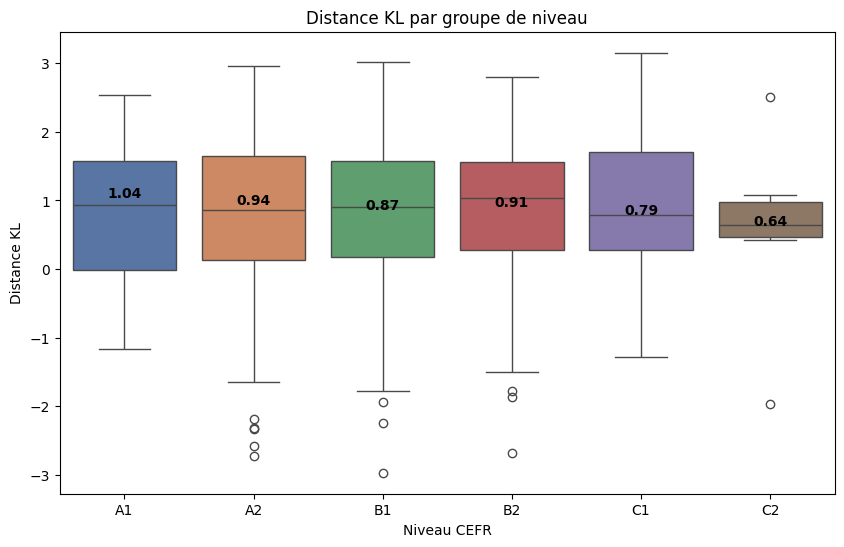

<Figure size 640x480 with 0 Axes>

In [38]:
# Le DataFrame à partir du dictionnaire
df_cefr = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cefr_dict.items()]))
#df_cefr.to_csv('/content/gdrive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/distance_KL.csv', index=True)

# Diagramme en boîte avec Seaborn
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=df_cefr[["A1", "A2", "B1", "B2", "C1", "C2"]], palette="deep")

# Ajouter les valeurs médianes sur le graphique
medians = df_cefr.median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}',
             horizontalalignment='center',
             size='medium',
             color='black',
             weight='semibold')

# Ajouter un titre et des labels
plt.title("Distance KL par groupe de niveau")
plt.xlabel("Niveau CEFR")
plt.ylabel("Distance KL")

plt.show()
plt.savefig("/content/gdrive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/boxplot_distance_KL_all.png")


   mean_proba  predicted_bin  event_rate
0    0.070159           1245    0.066667
1    0.149294           2395    0.126931
2    0.249118           2248    0.199733
3    0.348988           2029    0.273534
4    0.450567           1854    0.348975
5    0.549203           1673    0.446503
6    0.650070           1413    0.514508
7    0.749198           1523    0.608011
8    0.852938           1733    0.714368
9    0.970387           4820    0.899378
   mean_proba  predicted_bin  event_rate
0    0.073552           5195    0.059673
1    0.143189           7112    0.112627
2    0.243924           3188    0.192597
3    0.346010           1761    0.226576
4    0.446001           1134    0.244268
5    0.546894            865    0.331792
6    0.648587            592    0.363176
7    0.748728            437    0.409611
8    0.850007            318    0.613208
9    0.954790            331    0.848943


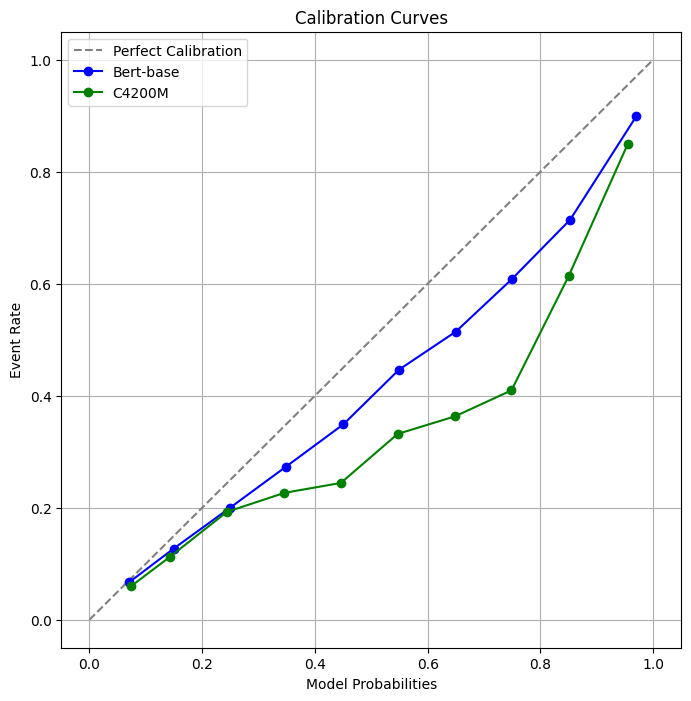

In [37]:
final_bert = pd.DataFrame()

final_bert["mean_proba"] = [df_table_bert[i].mean() for i in range(10)]
final_bert["predicted_bin"] = [df_table_bert[i].count() for i in range(10)]
final_bert["event_rate"] =  [sucess_per_bin_bert[i] / final_bert["predicted_bin"].iloc[i] for i in range(10)]
print(final_bert.head(10))

x_bert = final_bert["mean_proba"].tolist()
y_bert = final_bert["event_rate"].tolist()

final_c4200m = pd.DataFrame()

final_c4200m["mean_proba"] = [df_table_c4200m[i].mean() for i in range(10)]
final_c4200m["predicted_bin"] = [df_table_c4200m[i].count() for i in range(10)]
final_c4200m["event_rate"] =  [sucess_per_bin_c4200m[i] / final_c4200m["predicted_bin"].iloc[i] for i in range(10)]
print(final_c4200m.head(10))

x_c4200m = final_c4200m["mean_proba"].tolist()
y_c4200m = final_c4200m["event_rate"].tolist()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.plot(x_bert, y_bert, color="b", linestyle="solid", marker="o", label="Bert-base")
plt.plot(x_c4200m, y_c4200m, color="g", linestyle="solid", marker="o", label="C4200M")

plt.xlabel("Model Probabilities")
plt.ylabel("Event Rate")
plt.title("Calibration Curves")
plt.legend(loc="best")
plt.grid(True)
plt.savefig("/content/gdrive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/calibration_curve_all.png")